In [5]:
import torch 
import torch.nn as nn 
import numpy as np
from log_util.logger import Logger
import utils.visualization as vis 

import matplotlib.pyplot as plt 
import seaborn
from envs.nonstationary_env import NonstationaryEnv
import pandas as pd
import seaborn as sns 
import torch.distributions as pyd
from torch.nn import functional as F
import gym 

In [6]:
import json 
import os 
def load_local_config(config_path):
    with open(config_path,'r') as f:
        local_config = json.load(f)
    local_config['device'] = 'cpu'
    local_config['use_wandb'] = False 
    local_config['use_remote'] = False 
    dir,name = os.path.split(config_path)
    new_name = 'local_' + name
    new_file_name = os.path.join(dir,new_name)
    with open(new_file_name,'w') as f:
        ser = json.dumps(local_config)
        f.write(ser)
    return new_file_name


In [7]:
local_toy = load_local_config("configs/pretrain_config_v2.json")


In [8]:
from algorithms.opt_Trainer import Opt_Trainer
from parameter.optm_Params import Parameters
from envencoder.advanced_encoder.e_encoder import UDP_Encoder
from envencoder.advanced_envencoder.udp_envencoder import UdpEnvencoder
# model =  UDP_Encoder(obs_dim=5,act_dim=2,emb_dim=2,max_env_num=10)
from agent.Tester import Tester


import gym
parameter = Parameters(config_path=local_toy,default_config_path="configs/default_config.json")
tester = Tester(parameter)


Defaul config path: configs/default_config.json
Use additional config
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/valuetarget1.pt..


In [9]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

def pca_analysis(embs,ids,need_pca = True,need_tsne = False):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    plt.cla()
    if type(embs) == list:
        n_env = len(embs)
        n_sample = embs[0].shape[0]
        env_id  = np.ones((n_env,n_sample))
        for i,id in enumerate(ids):
            env_id[i] = env_id[i] * id
        env_id = env_id.reshape(-1)
        ids = env_id
        embs = np.concatenate(embs,axis=0)
        embs = embs.reshape((n_env * n_sample,-1))
    if need_pca:
        pca = PCA(n_components=2)
        scaler = StandardScaler()
        embs = scaler.fit_transform(embs)
        principalComponents = pca.fit_transform(embs) 
    elif need_tsne:
        tsne = TSNE(n_components=2,perplexity=30,n_iter=300)
        principalComponents = tsne.fit_transform(embs)
    else:
        principalComponents = embs 
    sns.scatterplot(x= principalComponents[:,0],
                    y=principalComponents[:,1],
                    hue=ids.reshape(-1),
                    palette="deep",
                    ax = ax)
    ax.legend(loc = 'upper right',title = 'Task Id')
    ax.set_title(f"Embedding Analysis")
    return fig


def heatmap_analysis(heatmap):
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    n_row,n_col = heatmap.shape
    ylabs = [f"E{i}" for i in range(n_row)]
    xlabs = [f"E{i}" for i in range(n_col)]

    im = ax.imshow(heatmap)
    # ax.set_xticklabels(xlabs)
    # ax.set_yticklabels(ylabs)
    
    # ax.set_yticks(np.arange(len(ylabs)), labels = ylabs)
    plt.setp(ax.get_xticklabels(), rotation = 40,
         ha = "right", rotation_mode = "anchor")

         # Add the values to each cell
    # for i in range(len(ylabs)):
    #     for j in range(len(xlabs)):
    #         text = ax.text(j, i, round(heatmap[i, j], 2),
    #                    ha = "center", va = "center", color = "w")

    
    cbar = ax.figure.colorbar(im, ax = ax)
    cbar.ax.set_ylabel("Color bar", rotation = -90, va = "bottom")


    return fig


def plot_mean(embs):
    assert embs.ndim == 2
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.scatter(embs[:,0],embs[:,1])
    return fig

In [10]:
tester.data_collection(100000,True)

Data Collection Start with  0  Samples
Data Collection Done with  100000  Samples


### Embedding Analysis

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/valuetarget1.pt..


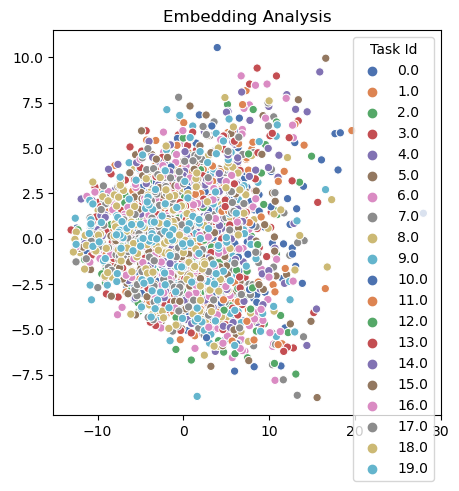

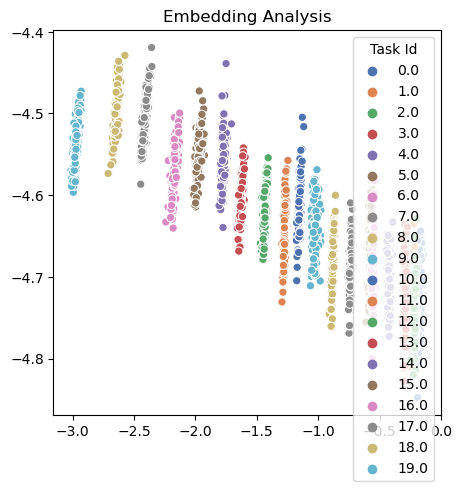

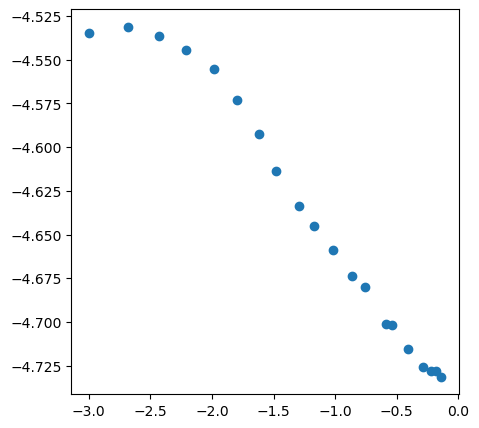

In [16]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_None")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/valuetarget1.pt..


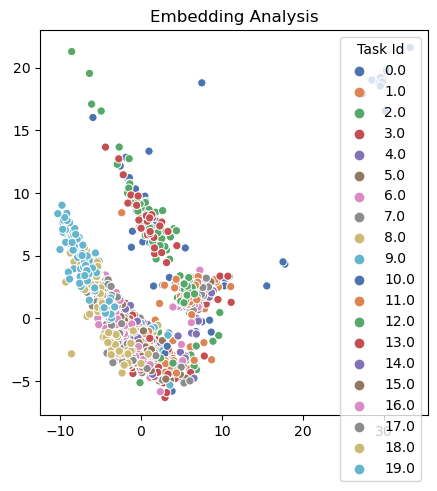

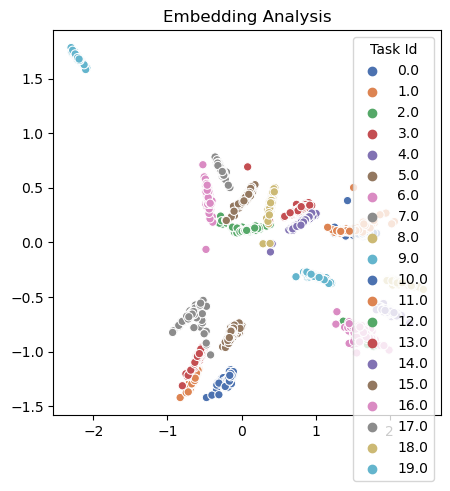

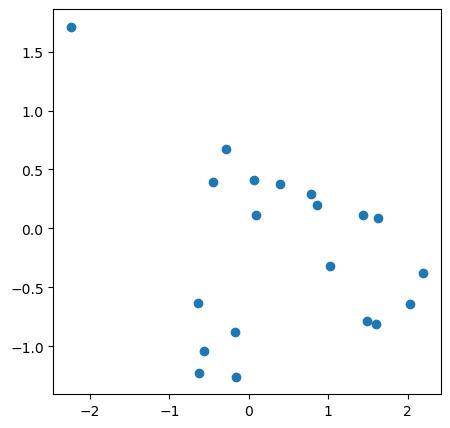

In [17]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/valuetarget1.pt..


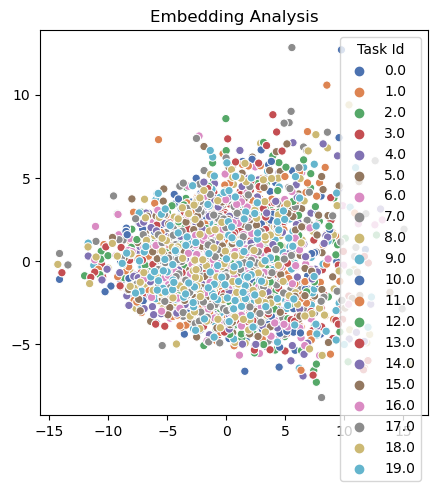

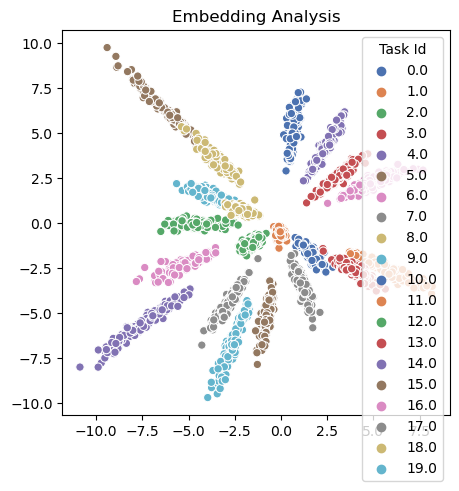

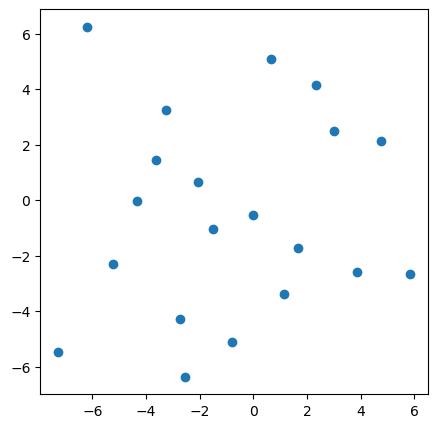

In [18]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/valuetarget1.pt..


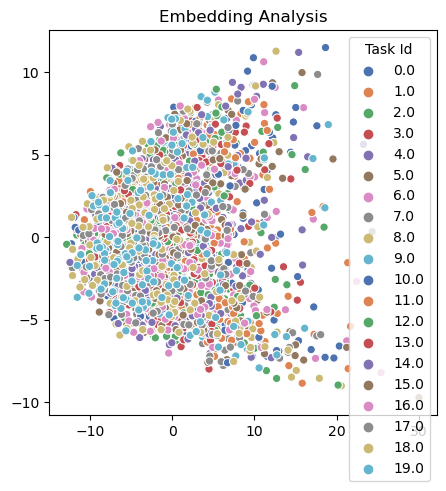

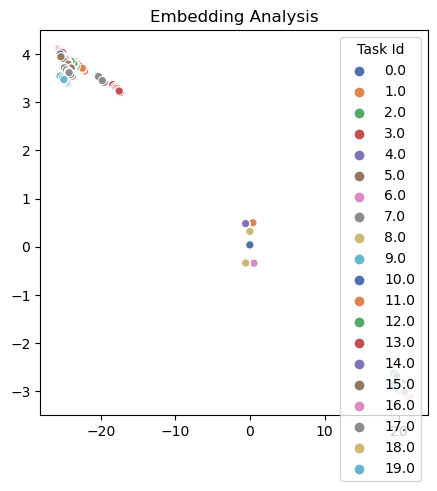

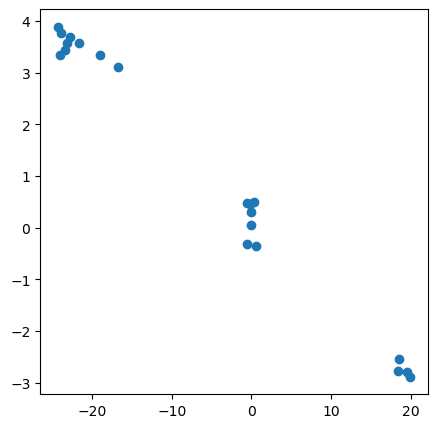

In [19]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/valuetarget1.pt..


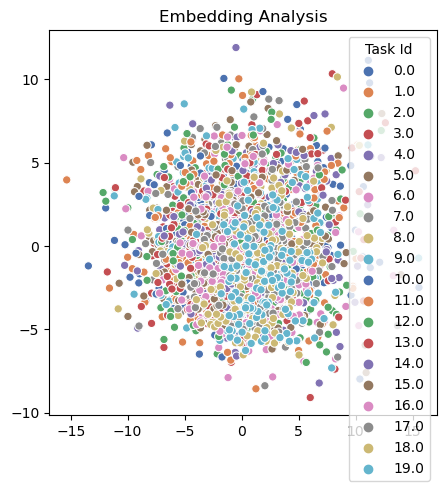

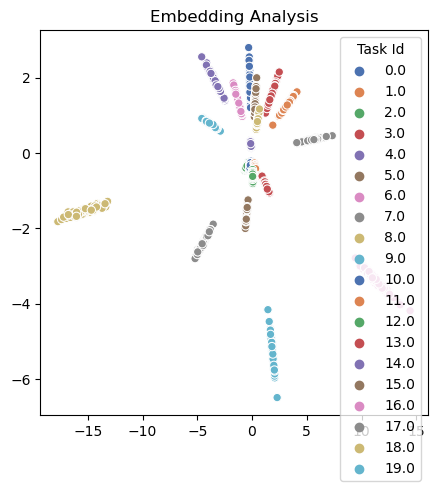

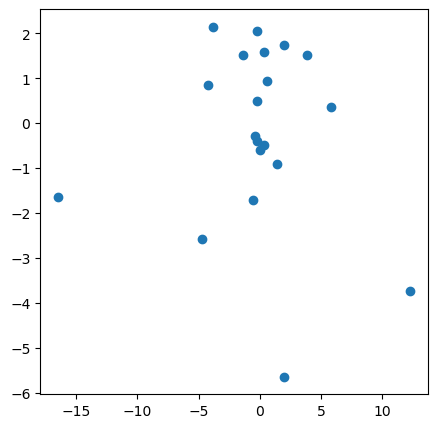

In [23]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/valuetarget1.pt..


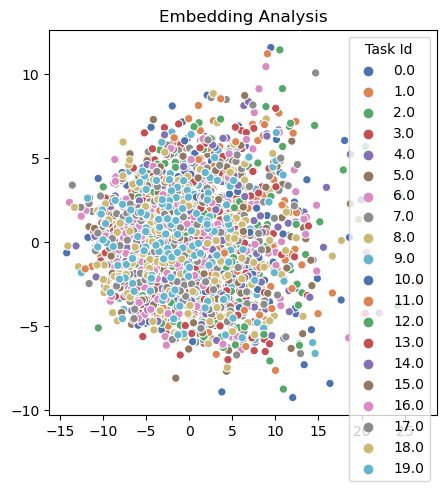

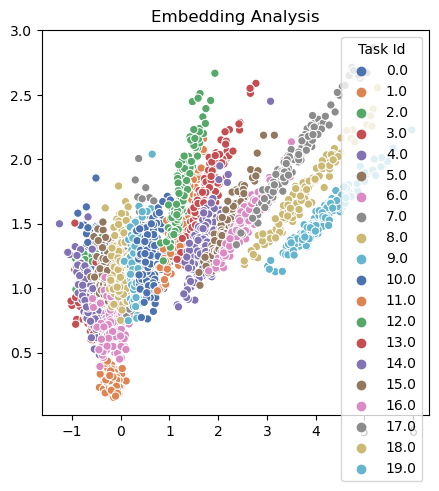

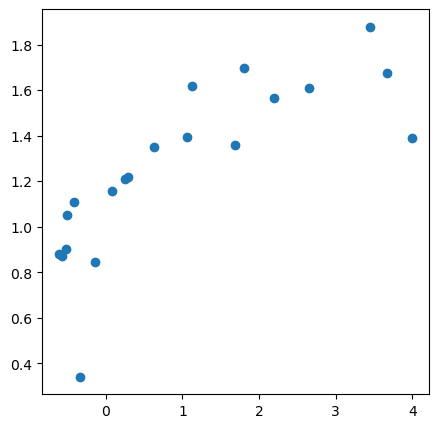

In [12]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/valuetarget1.pt..


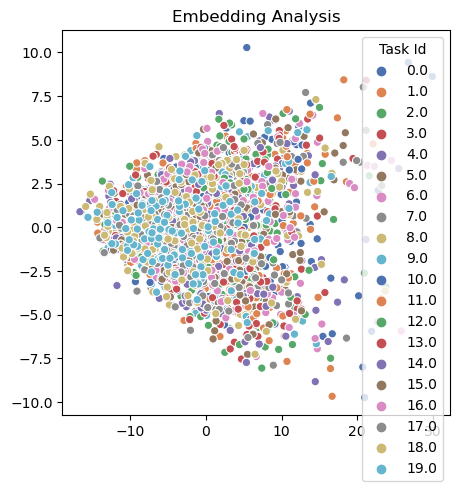

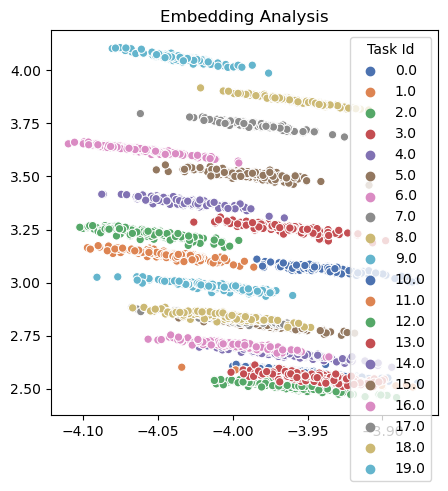

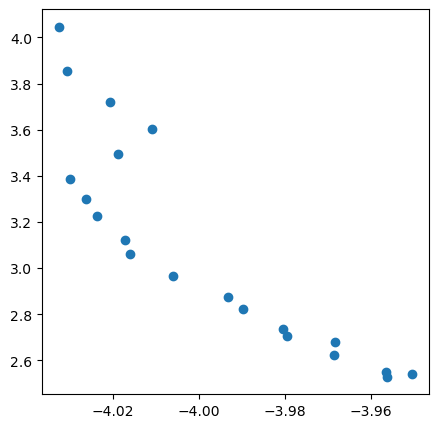

In [13]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3")
feature_list,emb_list,mean_emb = tester.emb_test(tester.replay_buffer,128)
fig = pca_analysis(feature_list,[i for i in range(len(feature_list))],need_pca = True)
fig2 = pca_analysis(emb_list,[i for i in range(len(feature_list))],need_pca = False)
fig3 = plot_mean(mean_emb)

### Heatmap

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_None/valuetarget1.pt..


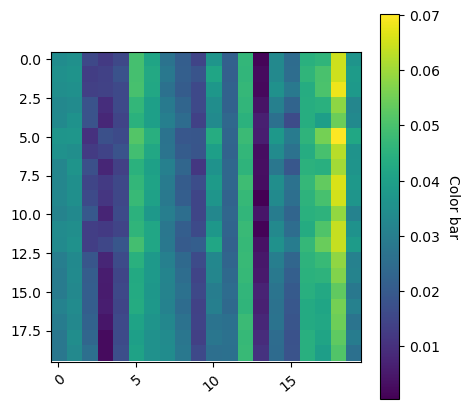

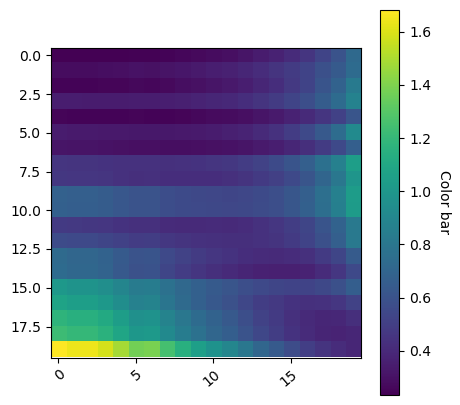

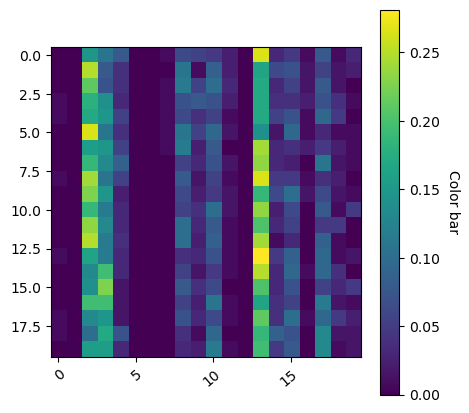

In [7]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_None")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)


loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2/valuetarget1.pt..


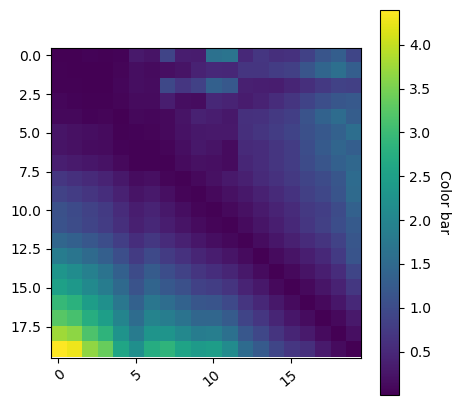

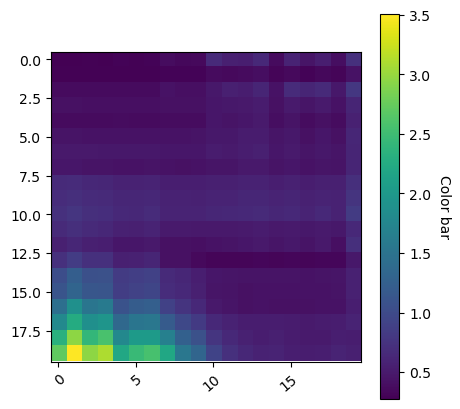

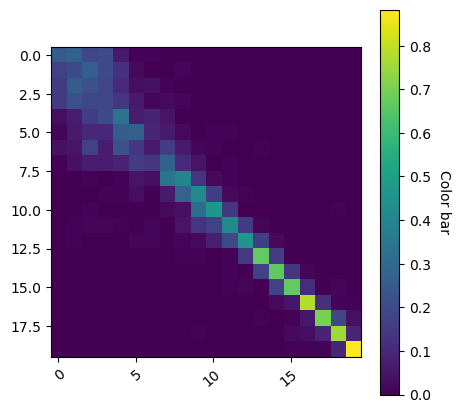

In [8]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy2")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2/valuetarget1.pt..


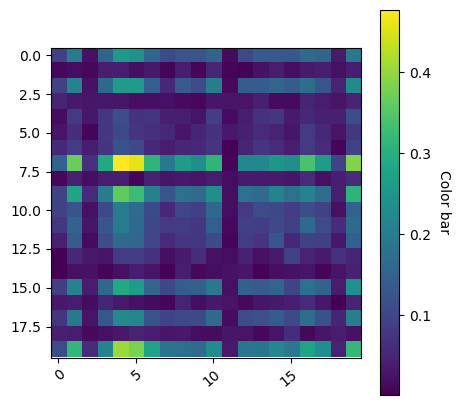

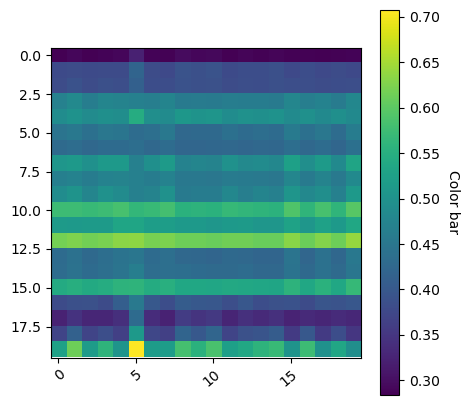

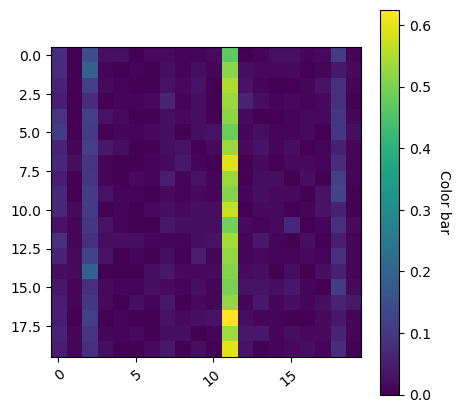

In [9]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_DPP2")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2/valuetarget1.pt..


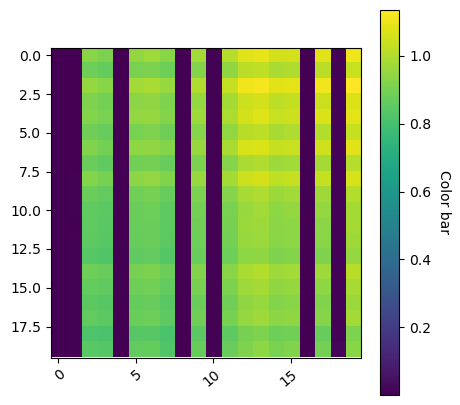

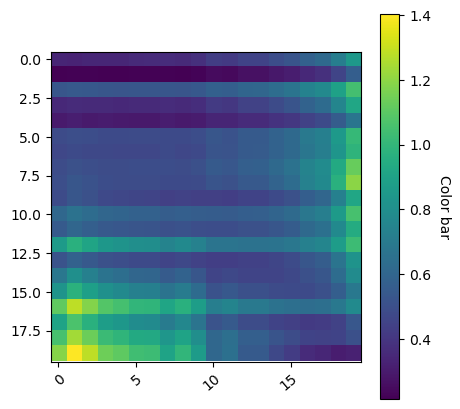

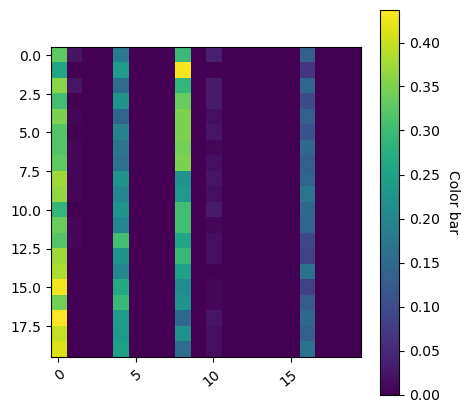

In [10]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_Entropy2")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine/valuetarget1.pt..


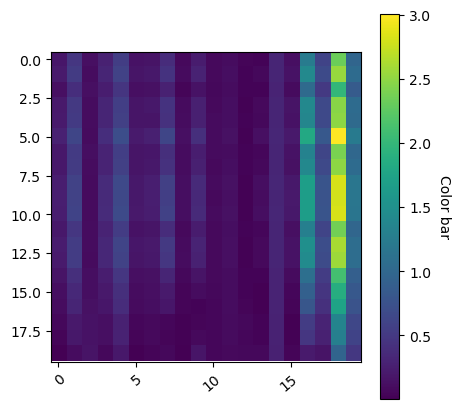

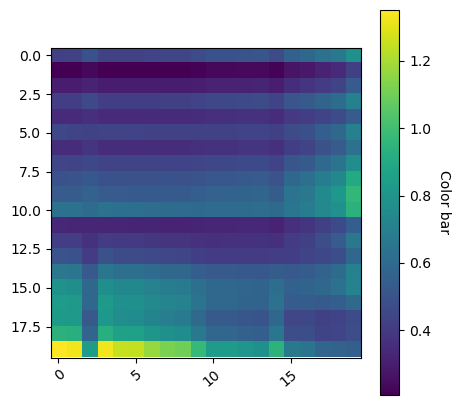

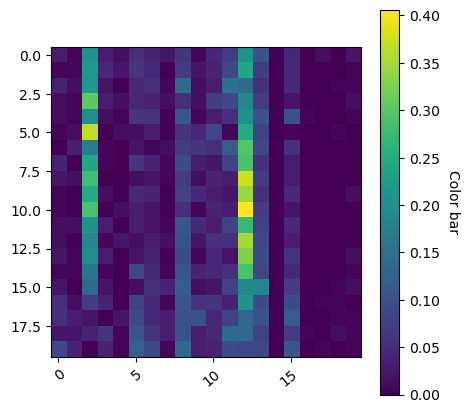

In [11]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_Cosine")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3/valuetarget1.pt..


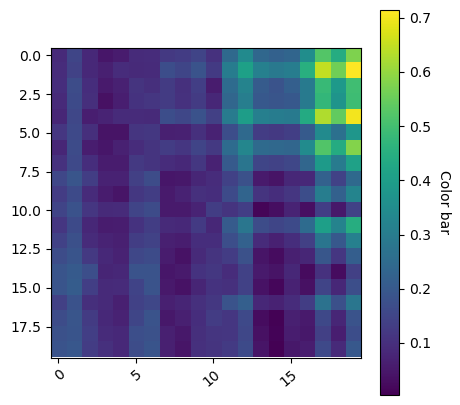

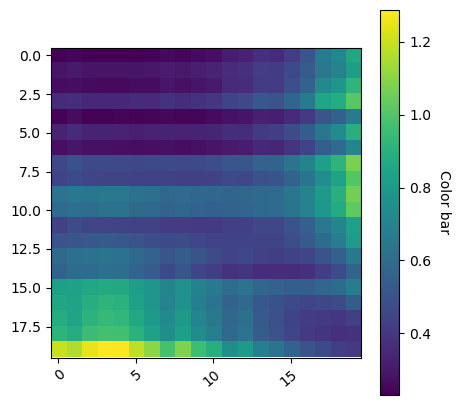

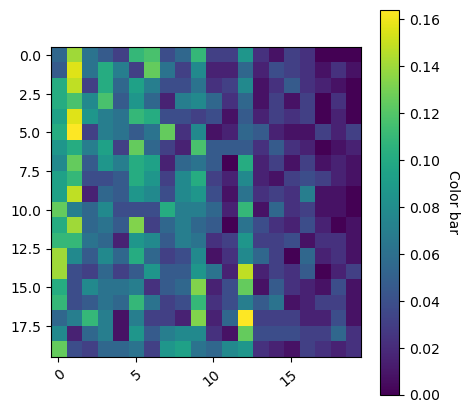

In [11]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_CrossEntropy3")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)

loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/mlppolicy.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/value0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/value1.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/valuetarget0.pt..
loading from data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3/valuetarget1.pt..


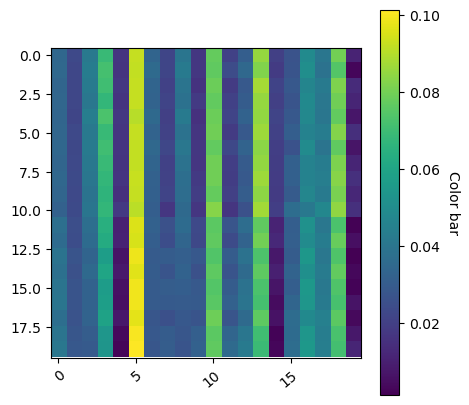

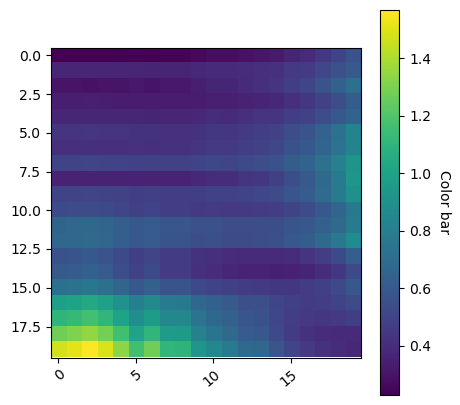

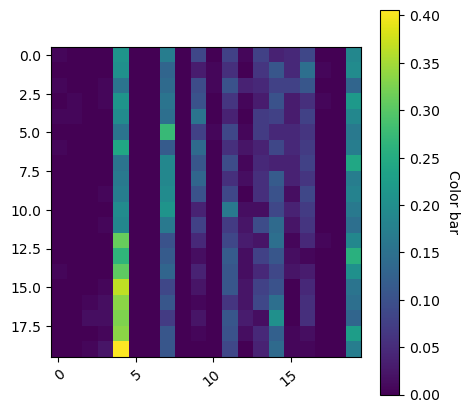

In [14]:
tester.load("data/HalfCheetah-v2-UDPEncoder-Pretrain_Certainty3")
dist_matrix,pred_er_matrix,predict_id_matrix = tester.dist_test(tester.replay_buffer,128)
fig1 = heatmap_analysis(dist_matrix)
fig2 = heatmap_analysis(pred_er_matrix)
fig3 = heatmap_analysis(predict_id_matrix)

# OOD Detection


In [12]:
from envencoder.optimization import MAML

maml = MAML(worker.envcoder.encoder,lr = 0.0001,first_order=True)
transition = worker.envcoder.transition 

## data collection, including OOD and ID
worker.non_stationary = False
list_embs,list_cof,list_real_parameter,trans = worker.raw_emb_collection(100,log_scale=4.0,n_tasks=10)

<AxesSubplot:xlabel='emb_x', ylabel='emb_y'>

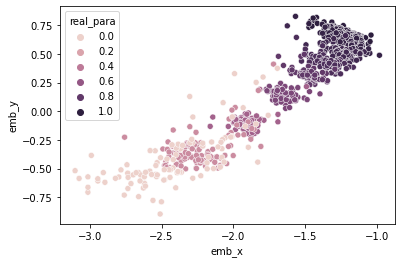

In [5]:
## Raw emb plotting 
raw_df = construct_df(list_embs,list_cof,list_real_parameter)

sns.scatterplot(x = 'emb_x',y = 'emb_y',data = raw_df,hue = 'real_para')

In [6]:

## calc error 
s = trans['s']
a = trans['a']
s2 = trans['s2']
s,a,s2,embs = torch.from_numpy(s).float(),torch.from_numpy(a).float(),torch.from_numpy(s2).float(),torch.from_numpy(list_embs).float()

with torch.no_grad():
    s2_pred ,_ = transition.forward(s,a,embs)
    err = (s2_pred - s2)**2
    err = torch.mean(err,dim = -1).mean(-1).numpy()

print(err)
print(np.argmax(err))



[0.1780523  0.153855   0.3119091  0.2618185  0.44232175 0.7790638
 1.0479702  0.99069977 2.4886367  3.6202934 ]
9


In [17]:
## all burn in 

supprot_x = s[9]
support_a = a[9]
support_x2 = s2[9]

learner = maml.clone()

for _ in range(80):
    emb_to_pred,_ = learner.forward(supprot_x,support_a,support_x2)
    loss ,info = transition._compute_loss(supprot_x,support_a,support_x2,emb_to_pred)
    learner.adapt(loss,first_order=True,allow_unused=True)


In [18]:
# new embs 
s = trans['s']
a = trans['a']
s2 = trans['s2']
s,a,s2 = torch.from_numpy(s).float(),torch.from_numpy(a).float(),torch.from_numpy(s2).float()
new_emb,_ = learner.forward(s,a,s2)
with torch.no_grad():
    s2_pred ,_ = transition.forward(s,a,new_emb)
    err = (s2_pred - s2)**2
    err = torch.mean(err,dim = -1).mean(-1).numpy()


# Embedding Analysis

In [ ]:
worker.non_stationary = False
list_embs,list_cof,list_real_parameter,trans = worker.raw_emb_collection(100,log_scale=3.0,n_tasks=50,)

In [6]:
s = trans['s']
a = trans['a']
s2 = trans['s2']
r = trans['r']
list_trans,list_paras = construct_trans(s,a,s2)
s,a,s2,embs = torch.from_numpy(s).float(),torch.from_numpy(a).float(),torch.from_numpy(s2).float(),torch.from_numpy(list_embs).float()
r = torch.from_numpy(r).float()
mean_embs = torch.mean(embs,dim = 1 )

_,logprob = trainer.encoder.transition.forward(s,a,embs,s2)
logprob = logprob.detach().numpy()


In [7]:
n_task = s.shape[0]
trans_matrix = np.zeros(shape=(n_task,n_task))
policy_matrix = np.zeros(shape=(n_task,n_task))
qvalue_matrix = np.zeros(shape = (n_task,n_task))
q_error = np.zeros(shape = (n_task,n_task))

for i in range(n_task):
    mean_emb = mean_embs[i:i+1]
    mean_emb = mean_emb.expand((100,-1))
    for j in range(n_task):
        tmp_s,tmp_a,tmp_s2,tmp_r = s[j],a[j],s2[j],r[j]
        with torch.no_grad():
            _,log_trans_prob =  trainer.encoder.transition.forward(tmp_s,tmp_a,mean_emb,tmp_s2)
            log_policy_prob = trainer.sac.policy.get_prob(tmp_s,tmp_a,mean_emb)
            qvalue = trainer.sac.value1.forward(tmp_s,tmp_a,mean_emb)
            chosen_action = trainer.sac.policy.act(tmp_s2,mean_emb,deterministic=True)
            next_q = trainer.sac.value1.forward(tmp_s2,chosen_action,mean_emb)
            error = torch.abs(next_q + tmp_r - qvalue)
        trans_matrix[i,j] = log_trans_prob.mean().numpy()
        policy_matrix[i,j] = log_policy_prob.mean().numpy()
        qvalue_matrix[i,j] = qvalue.mean().numpy() 
        q_error[i,j] = error.mean().numpy()
    


In [8]:
trans_matrix_df = pd.DataFrame(trans_matrix,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])
                    
policy_matrix_df = pd.DataFrame(policy_matrix,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])
qvalue_matrix_df = pd.DataFrame(qvalue_matrix,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])
q_error_matrix_df = pd.DataFrame(q_error,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])

<AxesSubplot:>

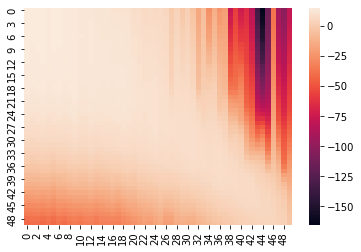

In [9]:
sns.heatmap(trans_matrix_df)

<AxesSubplot:>

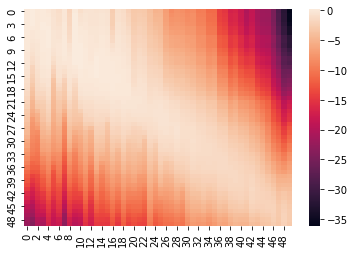

In [10]:
sns.heatmap(policy_matrix_df)

<AxesSubplot:>

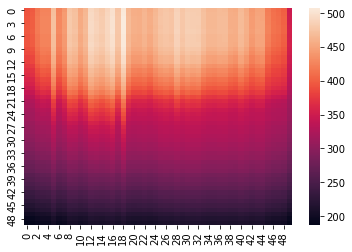

In [11]:
sns.heatmap(qvalue_matrix_df)

<AxesSubplot:>

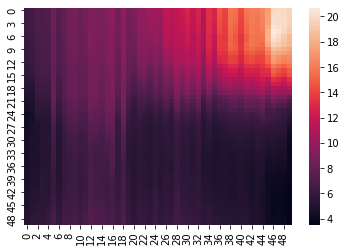

In [12]:
sns.heatmap(q_error_matrix_df)

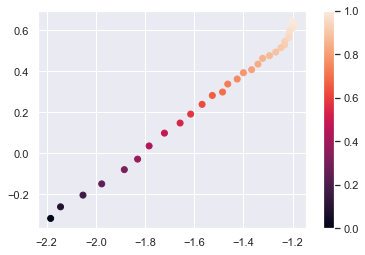

In [51]:
## Parameter 
plt.scatter(mean_embs[:,0],mean_embs[:,1],c = np.mean(list_real_parameter,axis=1)[:,-1])
plt.colorbar()

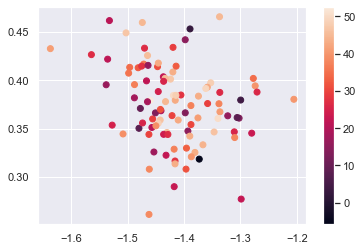

In [37]:
embs_to_plot = embs[2]
logprob_to_plot = logprob[2]
plt.scatter(x = embs_to_plot[:,0],
            y = embs_to_plot[:,1],
            c=logprob_to_plot)
plt.colorbar()
plt.show()

# Detection

In [20]:
embs,change_inds,real_param,logs= worker.ns_test(200,log_scale=7.0,n_tasks=5,ns_sequence=[0,4,1,3,2],ns_period=50)

/Users/jijingtian/opt/anaconda3/envs/meta/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/jijingtian/Documents/GitHub/RL/Project/Optimization_Encoder/agent/Worker.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'G':np.array(Gs),


1. 目的是在两个 change point 中检测正确，包括
   1. 初始化的适应
   2. 第一个 change point 的 detect + estimate 

In [14]:
center_x = 1.2192 + 3.6576 + 6.4008 + 21.9456 + 6.4008
center_y = 4.3180 / 2 

up_x = center_x - 1.8288
up_y = center_y

right_x = center_x
right_y = center_y + 1.8288

down_x = center_x + 1.8288
down_y = center_y 

left_x = center_x
left_y = center_y - 1.8288 

print("Center: ",center_x,center_y)
print("Up: ",up_x,up_y)
print("Right: ",right_x,right_y)
print("Down: ",down_x,down_y)
print("Left: ",left_x,left_y)

Center:  39.623999999999995 2.159
Up:  37.795199999999994 2.159
Right:  39.623999999999995 3.9878
Down:  41.452799999999996 2.159
Left:  39.623999999999995 0.3301999999999998


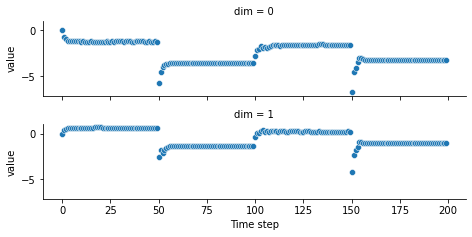

In [21]:
fig = vis.embedding_variation(embs)

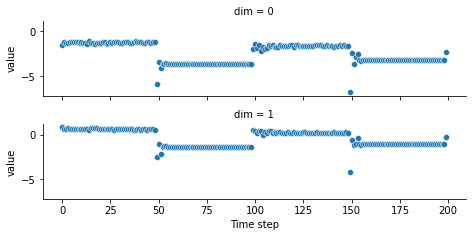

In [22]:
fig = vis.embedding_variation(logs['raw_embs'])

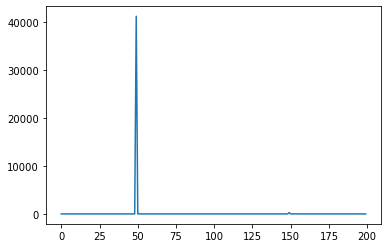

In [23]:
plt.plot(logs['G'])
# plt.plot(logs['s'])
# plt.plot(logs['S'])

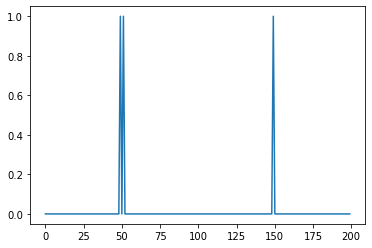

In [24]:
plt.plot(logs['detect_flag'])


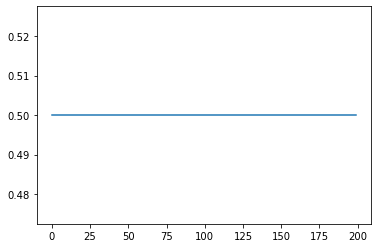

In [12]:
plt.plot(logs['Confidence'])